In [1]:
%matplotlib inline
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import os
import seaborn as sns
import skimage
from skimage import io, transform
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

In [2]:
def data_transforms(phase):
    if phase == 'train':
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
        
    if phase == 'validation':
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])       
        
    return transform
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
image_datasets = {x: datasets.ImageFolder(os.path.join("D:/Айнур/ML/xray_classifier/", x), data_transforms(x)) 
                  for x in ['validation','train']}

dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size = 4, shuffle=True), 
               'validation': torch.utils.data.DataLoader(image_datasets['validation'], batch_size = 1, shuffle=False)}

In [4]:
len(dataloaders['train'])

1047

In [5]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
classes = image_datasets['train'].classes
class_names = image_datasets['train'].classes

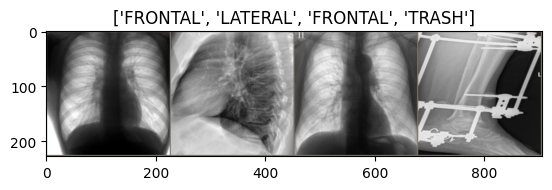

In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  


inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [7]:
inputs, classes = next(iter(dataloaders['train']))

In [8]:

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch+1, num_epochs))
        print("="*10)
        
        for phase in ['train', 'validation']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for data in dataloaders[phase]:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model

In [9]:
model_pre = models.vgg19(weights='DEFAULT')

In [10]:
for param in model_pre.features.parameters():
    param.required_grad = False

num_features = model_pre.classifier[6].in_features
features = list(model_pre.classifier.children())[:-1] 
features.extend([nn.Linear(num_features, len(class_names))])
model_pre.classifier = nn.Sequential(*features) 
print(model_pre)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [11]:
model_pre = model_pre.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_pre.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [12]:
model_pre = train_model(model_pre, criterion, optimizer, exp_lr_scheduler, num_epochs=30)

Epoch: 1/30


C:\Users\Ainur\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


train Loss: 0.0779 Acc: 0.9737
validation Loss: 0.5679 Acc: 0.8779
Epoch: 2/30
train Loss: 0.0199 Acc: 0.9943
validation Loss: 0.0933 Acc: 0.9590
Epoch: 3/30
train Loss: 0.0049 Acc: 0.9993
validation Loss: 0.1632 Acc: 0.9139
Epoch: 4/30
train Loss: 0.0043 Acc: 0.9988
validation Loss: 0.2181 Acc: 0.9029
Epoch: 5/30
train Loss: 0.0227 Acc: 0.9955
validation Loss: 0.7067 Acc: 0.8428
Epoch: 6/30
train Loss: 0.0281 Acc: 0.9912
validation Loss: 0.3730 Acc: 0.8689
Epoch: 7/30
train Loss: 0.0211 Acc: 0.9938
validation Loss: 0.3102 Acc: 0.8929
Epoch: 8/30
train Loss: 0.0396 Acc: 0.9883
validation Loss: 0.2802 Acc: 0.8939
Epoch: 9/30
train Loss: 0.0397 Acc: 0.9876
validation Loss: 0.1330 Acc: 0.9590
Epoch: 10/30
train Loss: 0.0117 Acc: 0.9967
validation Loss: 0.1381 Acc: 0.9499
Epoch: 11/30
train Loss: 0.0057 Acc: 0.9990
validation Loss: 0.1774 Acc: 0.9199
Epoch: 12/30
train Loss: 0.0050 Acc: 0.9998
validation Loss: 0.1420 Acc: 0.9479
Epoch: 13/30
train Loss: 0.0048 Acc: 0.9998
validation Loss: 

## Тестирование модели

In [13]:

def test_model():
    running_correct = 0.0
    running_total = 0.0
    true_labels = []
    pred_labels = []
    f = open("test_y", "w")
    with torch.no_grad():
        for data in dataloaders['validation']:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            true_labels.append(labels.item())
            outputs = model_pre(inputs)
            _, preds = torch.max(outputs.data, 1)
            pred_labels.append(preds.item())
            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()
        acc = running_correct/running_total
    return (true_labels, pred_labels, running_correct, running_total, acc)

In [14]:
true_labels, pred_labels, running_correct, running_total, acc = test_model()

In [15]:
print("Total Correct: {}, Total Test Images: {}".format(running_correct, running_total))
print("Test Accuracy: ", acc)


Total Correct: 958.0, Total Test Images: 999.0
Test Accuracy:  0.958958958958959


In [16]:
true_labels, pred_labels, running_correct, running_total, acc = test_model()

In [17]:
import os


In [18]:
#Список классов
cats = ["frontal", "lateral", "trash"]

In [19]:
def prediction():
    df = pd.DataFrame(columns = ['image_id',"frontal", "lateral", "trash"])
    running_correct = 0.0
    running_total = 0.0
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        for j,data in enumerate(dataloaders['validation']):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            true_labels.append(labels.item())
            outputs = model_pre(inputs).squeeze()
            outputs1 = model_pre(inputs)
            _, preds = torch.max(outputs1.data, 1)
            res = outputs.softmax(dim = 0).sort(descending = True)
            #Получение имени файла
            img_id = os.path.basename(dataloaders['validation'].dataset.samples[j][0])
            row = {'image_id': img_id}
            for s,i in zip(res[0][:3], res[1][:3]):
                row[cats[i]] = s.item()
            df_row = pd.DataFrame([row])
            df = pd.concat([df,df_row])
    return df
  
    

In [20]:
df = prediction()

C:\Users\Ainur\AppData\Local\Temp\ipykernel_12952\2156954341.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df_row])


In [21]:
df.head()

,image_id,frontal,lateral,trash
0,1.2.392.200036.9110.1.2004392122.1.1.202112131...,0.999955,0.000020,0.000025
0,1.2.392.200036.9116.1.1.1.1.11220621.202112010...,0.767546,0.110988,0.121466
0,1.2.392.200036.9116.1.1.1.1.11220621.202112201...,0.359400,0.114512,0.526087
0,1.2.392.200036.9116.1.1.1.1.11221221.202201191...,0.633150,0.057736,0.309114
0,1.3.6.1.4.1.39687.1.4612501804798937590.795163...,0.456173,0.272486,0.271341


In [22]:
df.to_csv('out.csv', index=False)  

In [24]:
torch.save(model_pre.state_dict(), 'weights.pth')